# GLEE: Geometric Laplacian Eigenmap Embedding

GLEE can be used in two different ways. This notebook contains an example use case when `glee` is imported into your Python session. For an example use case from the command line, see the README.md file.

## Example use case

First, we load a small graph with $34$ nodes and compute its 8-dimensional embedding.

In [1]:
import networkx as nx
graph = nx.karate_club_graph()

from glee import eigenmaps
emb = eigenmaps(graph, 8, method='glee')

The result contains the embedding of each node as rows. The rows are ordered in the same order as `graph.nodes()`.

In [2]:
emb.shape

(34, 8)

Using the geometric interpretation of these embeddings, we can approximate the number of common neighbors between a pair of nodes.

In [3]:
import numpy as np

def common(graph, emb):
    pairs = [(i, j)
             for i in range(graph.order())
             for j in range(i + 1, graph.order())
             if (i, j) not in graph.edges()]

    common_neighbors = [len(set(graph.neighbors(i)) & set(graph.neighbors(j)))
                        for (i, j) in pairs]

    approx_common_neighbors = [- graph.degree(i) * \
                               np.sum([emb[i].dot(emb[n]) for n in graph.neighbors(j)]) / len(graph.neighbors(i))
                               for (i, j) in pairs]
    return common_neighbors, approx_common_neighbors

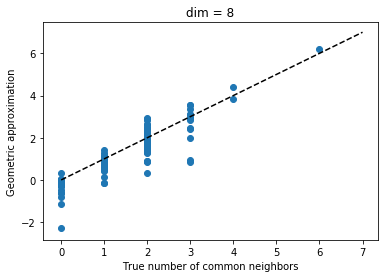

In [4]:
import matplotlib.pylab as plt

def make_plot(graph, emb):
    plt.plot([0, 7], [0, 7], 'k--')
    plt.scatter(*common(graph, emb))
    plt.title('dim = 8')
    plt.xlabel('True number of common neighbors')
    plt.ylabel('Geometric approximation')
    plt.show()
    
make_plot(graph, emb)

Moreover, this approximation improves as the embedding dimension improves.

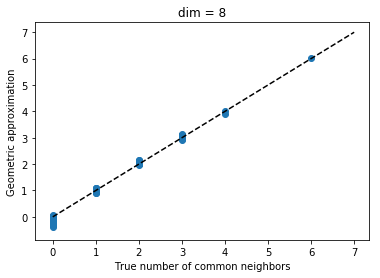

In [5]:
make_plot(graph, eigenmaps(graph, 32, method='glee'))

## Visualization

In [29]:
HL_COLOR = '#93c47dff'
DEF_COLOR = '#999999'

def plot_arrows(points, ax, highlight, hl_color=HL_COLOR, lines=None):
    if lines is None:
        lines = []
    for idx, row in enumerate(points):
        color = hl_color if idx in highlight else DEF_COLOR
        if idx not in lines:
            ax.annotate('', xy=row, xytext=(0, 0), annotation_clip=True,
                        arrowprops={'headwidth': 3, 'headlength': 4,
                                    'width': 1, 'color': color})
        else:
            ax.plot([0, row[0]], [0, row[1]], color=color)


def plot_glee(points, highlight, max_val, lines=None):
    """PLot 2D-GLEE of a graph."""
    ax = plt.gca()
    plot_arrows(points, ax, highlight, lines=lines)
    ax.set_aspect('equal')
    ax.set_ylim(-max_val, max_val)
    ax.set_xlim(-max_val, max_val)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])

def plot_perpendicular(ax, row, neighbors):
    perp = np.array([-row[1], row[0]])
    points = np.array([-20*perp, 20*perp])
    ax.plot(points.T[0], points.T[1], ':')
    # just draw over the previous
    highlight = list(range(len(neighbors)))
    plot_arrows(neighbors, ax, highlight, hl_color='#8e7cc3ff')


def plot_karate(hl_node):
    plt.figure()
    graph = nx.karate_club_graph()
    simpl = eigenmaps(graph, method='glee', dim=2)
    # The eigenvectors can rotate, and for this picture we want a
    # particular orientation/rotation of them.
    while not np.allclose(simpl[0], [-0.82511663, -3.885854]):
        simpl = eigenmaps(graph, method='glee', dim=2)

    plot_glee(simpl, [hl_node], 1, [0, 32, 33])
    plot_perpendicular(plt.gca(), simpl[hl_node], [simpl[n] for n in graph.neighbors(hl_node)])
    plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6])
    plt.gca().set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
    plt.xlim(-0.3, 0.6)
    plt.ylim(-0.3, 0.6)


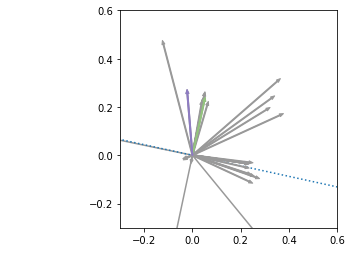

In [43]:
plot_karate(np.random.choice(range(graph.order())))
plt.show()

In the figure, the dotted blue line is orthogonal to the embedding of node $0$. Observe that most of its neighbors (purple arrows) have embeddings far from orthogonal